In [29]:
from src.experiments.self_learning_experiment import SelfLearningExperiment, SelfLearningExperimentArgs
from src.args.yaml_config import YamlConfig

yaml_config = YamlConfig().config
config = SelfLearningExperimentArgs(
    experiment_id="self_learning_experiment",
    sam_model="vit_b",
    learning_rate=3e-4,
    image_encoder_lr=1e-4,
    prompt_encoder_lr=3e-3,
    mask_decoder_lr=1e-3,
    batch_size=8,
    epochs=100,
    weight_decay=1e-4,
    warmup_epochs=5,
    ema_decay_origin=0.5,
    early_stopping_patience=10,
    visualize_n_segmentations=5,
    lower_confidence_quantile=0.3,
    upper_confidence_quantile=0.7, 
    gamma=0.85,
    step_size=5,
    best_model_metric="IoU",
    minimize_best_model_metric=False,
    from_checkpoint="/dhc/home/leon.hermann/MP/mp-lippert-experiments/results/multi_ds_vessel_experiment/tuning_full_model/2025-01-25_18#08#59/model.pt",
)

experiment = SelfLearningExperiment(dict(config), yaml_config)

/dhc/home/leon.hermann/MP/mp-lippert-experiments/src/models/segment_anything/build_sam.py:118: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)
/dhc/

ImageNet pretrained weights for HarDNet68 is loaded
loading model from checkpoint /dhc/home/leon.hermann/MP/mp-lippert-experiments/results/multi_ds_vessel_experiment/tuning_full_model/2025-01-25_18#08#59/model.pt

ImageNet pretrained weights for HarDNet68 is loaded


/dhc/home/leon.hermann/MP/mp-lippert-experiments/src/experiments/self_learning_experiment.py:70: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(self.base_config.fr

In [30]:
unlabeled_loader = experiment._create_dataloader('train')
teacher_model = experiment.model
iter_unlabeled = iter(unlabeled_loader)

In [31]:
from src.models.auto_sam_model import norm_batch


batch = next(iter_unlabeled).cuda()
teacher_model.eval()
images = batch.input
pseudo_labels = norm_batch(teacher_model.forward(batch).logits)

OutOfMemoryError: CUDA out of memory. Tried to allocate 346.00 MiB. GPU 0 has a total capacity of 44.35 GiB of which 249.75 MiB is free. Including non-PyTorch memory, this process has 44.10 GiB memory in use. Of the allocated memory 43.30 GiB is allocated by PyTorch, and 500.60 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [35]:
import torch
lower_threshold = torch.quantile(pseudo_labels.float(), 0.7).item()
upper_threshold = torch.quantile(pseudo_labels.float(), 0.95).item()
print(lower_threshold, upper_threshold)

0.002306415466591716 0.8250343799591064


In [36]:
pseudo_labels.shape

torch.Size([8, 1, 256, 256])

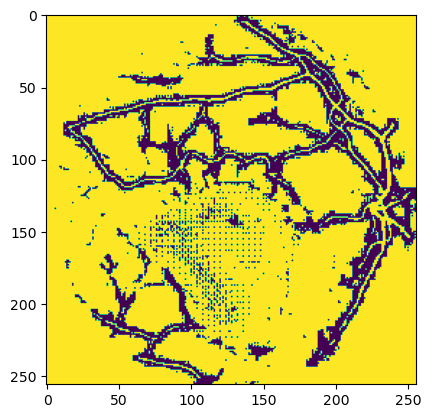

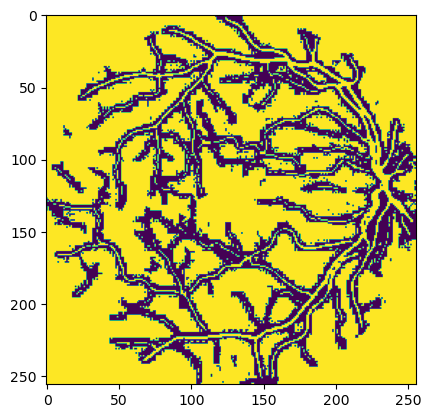

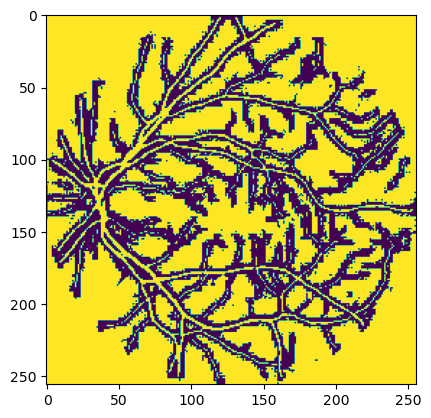

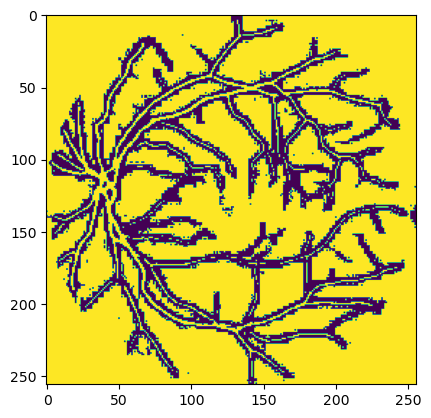

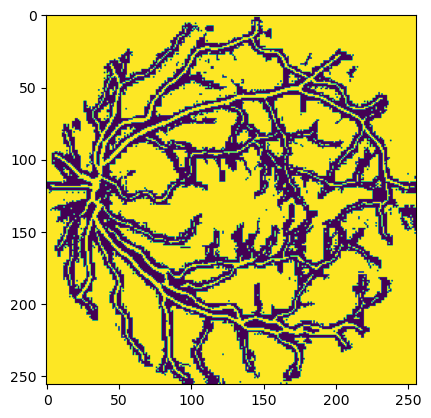

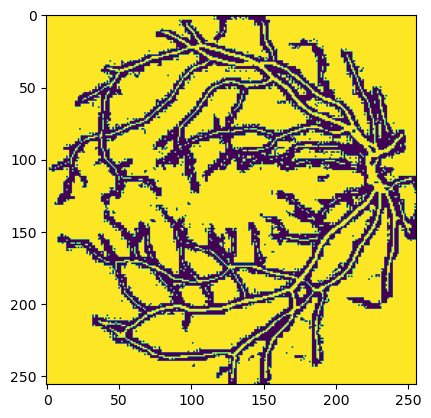

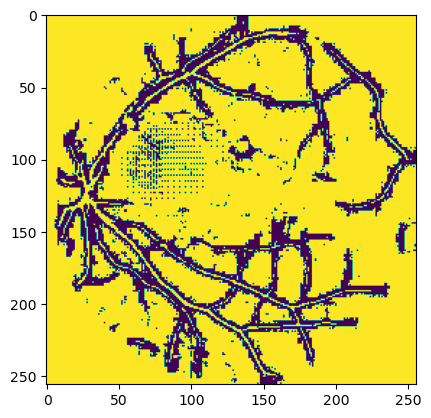

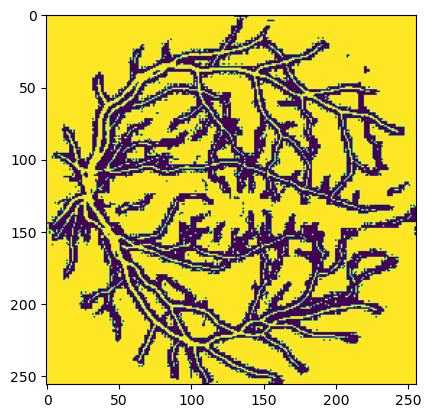

In [37]:
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

# Threshold pseudo_labels
high_confidence_pseudo_labels = torch.logical_or(pseudo_labels > upper_threshold, pseudo_labels < lower_threshold).float()
thresholded_pseudo_labels = (pseudo_labels > 0.5).float()

for i in range(8):
    image = images[i].cpu().numpy().transpose(1, 2, 0)
    #pseudo_label = F.interpolate(thresholded_pseudo_labels[i].unsqueeze(0), size=(1024, 1024), mode='bilinear', align_corners=False).squeeze(0).detach().cpu().numpy().transpose(1, 2, 0)
    pseudo_label = thresholded_pseudo_labels[i].detach().cpu().numpy().transpose(1, 2, 0)
    #mask = F.interpolate(high_confidence_pseudo_labels[i].unsqueeze(0), size=(1024, 1024), mode='bilinear', align_corners=False).squeeze(0).detach().cpu().numpy().transpose(1, 2, 0)
    mask = high_confidence_pseudo_labels[i].detach().cpu().numpy().transpose(1, 2, 0)
    
    alpha = mask.squeeze().astype(float)
    
    #plt.imshow(image, alpha=alpha*0.5)
    #plt.imshow(pseudo_label, alpha=alpha*0.5)
    plt.imshow(alpha)
    plt.show()